In [1]:
#lib
import pandas as pd
import os
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import time

In [2]:
fasttext.FastText.eprint = lambda x: None

In [43]:
# Provide the path to your CSV file
file_path = 'dataset/labeled_lang_data_processed.csv'


# Check pandas version
version = pd.__version__

# Load the CSV file into a DataFrame
custom_headers = ["sentence","lang_tag"]
if version >= '1.3.0':
    # Use 'on_bad_lines' for pandas version 1.3.0 and above
    df = pd.read_csv(file_path, sep='\t', header=None, names=custom_headers, on_bad_lines='skip')
else:
    # Use 'error_bad_lines' for older pandas versions
    df = pd.read_csv(file_path, sep='\t', header=None, names=custom_headers, error_bad_lines=False)

# Display the first few rows of the dataset
df.head()

,sentence,lang_tag
0,"সোমবাৰে , ষ্টেনফ ' ৰ্ড ইউনিভাৰচিটি স্কুল অৱ মে...",__label__asm_Beng
1,"শীৰ্ষ গৱেষকে কয় যে এইটোৱে কেন্সাৰ , যক্ষ্মা , ...",__label__asm_Beng
2,স্থানীয় সময় ( 0230 utc ) অনুসৰি পুৱা 9 : 30 ...,__label__asm_Beng
3,পাইলটগৰাকী স্কুৱাড্ৰন লীডাৰ ডিলক্ৰিট পাটাভি বু...,__label__asm_Beng
4,স্থানীয় সংবাদ মাধ্যমে সঁহাৰি জনাওতে বিমানবন্দৰ...,__label__asm_Beng


In [44]:
df.columns

Index(['sentence', 'lang_tag'], dtype='object')

In [45]:
df.size

1017768

In [46]:
print(df["lang_tag"].unique())#all diff languages

['__label__asm_Beng' '__label__awa_Deva' '__label__ben_Beng'
 '__label__bho_Deva' '__label__brx_Deva' '__label__dgo_Deva'
 '__label__gom_Deva' '__label__guj_Gujr' '__label__hin_Deva'
 '__label__hne_Deva' '__label__kan_Knda' '__label__kas_Arab'
 '__label__kas_Deva' '__label__lus_Latn' '__label__mag_Deva'
 '__label__mai_Deva' '__label__mal_Mlym' '__label__mar_Deva'
 '__label__mni_Beng' '__label__mni_Mtei' '__label__npi_Deva'
 '__label__ory_Orya' '__label__pan_Guru' '__label__san_Deva'
 '__label__sat_Olck' '__label__snd_Arab' '__label__snd_Deva'
 '__label__tam_Taml' '__label__tel_Telu' '__label__urd_Arab'
 '__label__en_Latn']


In [53]:

# Filter sentences with < 20 characters
filtered_df = df[
    (df['sentence'].str.len() < 20) & 
    (df['sentence'].str.len()  > 15)
]

# Group by `lang_tag` and take required counts
output = pd.concat([
    filtered_df[filtered_df['lang_tag'] == '__label__asm_Beng'].head(2),
    filtered_df[filtered_df['lang_tag'] == '__label__en_Latn'].head(1),
    filtered_df[filtered_df['lang_tag'] == '__label__hin_Deva'].head(2)
]).reset_index(drop=True)

# Use `.head()` to show the result (limit to first 5 rows if necessary)
output.head(5)

,sentence,lang_tag
0,মই একো বুজা নাই !,__label__asm_Beng
1,১৩ খন মেডিকেল কলেজ,__label__asm_Beng
2,thank you all .,__label__en_Latn
3,"अन्य विशिष्ठगण ,",__label__hin_Deva
4,"भाईयों और बहनों ,",__label__hin_Deva


In [55]:

for x in df['sentence']:
    if x == "भाईयों और बहनों ,":
        print(1)

In [7]:

result = df[df['lang_tag'] == '__label__lus_Latn']['sentance']

result.head()

12961    thawhtanni khan , stanford university school o...
12962    research lama sulsutu te chuan he thil hian ca...
12963    jas 39c grispen chu dar 9 : 30 am local time (...
12964    a pilot chu an chhui leh naah squadron leader ...
12965    a chheh vela chanchinthar lakhawmtute chuan ai...
Name: sentance, dtype: object

In [8]:
#split dataset
# Split the dataset into training+validation (80%) and testing (20%)
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Split training+val(80%) into training(70%) and validation (10%)
train_df , val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

In [9]:
train_df.size

732792

In paper they make e trained separate classifiers for
native script (IndicLID-FTN) and roman script
(IndicLID-FTR). but in our data the only the __label__lus_Latn which is a roman script lang tag, hence results differ

In [10]:
#fast linear classifier
#wordNgrams = 
#save df in file for fasttext
# Prepare the text data in FastText format
# Ensure that labels are prefixed with "__label__"
def train_model(model_path, dim):
    i = 0
    with open('training_data.txt', 'w') as f:
        for index, row in train_df.iterrows():
            label = f"__label__{row[custom_headers[1]]}"
            text = row[custom_headers[0]]
            f.write(f"{label} {text}\n")
            if i % 100000 == 0:
                print(f"...running {i}")
            i = i + 1
    
    start_time = time.time()
    # Train the FastText model
    model = fasttext.train_supervised(
                        input = 'training_data.txt', 
                        loss = 'hs',
                        verbose = 1,
                        dim = dim,
                        autotuneValidationFile = 'validation_data.txt', 
                        autotuneDuration = 14400*3)#epoch not used since 1017768 sample
    training_time = time.time() - start_time
    model.save_model(model_path)
    return model, training_time

In [11]:
# Dimensions to test
dimensions = [8]#[4 , 8, 16]#, 32, 64, 128, 256, 512, 1024]
results = {'dim': [], 'precision': [], 'recall': [], 'f1': [], 'accuracy': [], 'throughput': []}

In [12]:
def test_model_custom(model, dim, training_time = 1):
    # Evaluate on the test set
    y_true = []
    y_pred = []
    
    print(len(test_df))
    
    for index, row in test_df.iterrows():
        label = row[custom_headers[1]]
        text = row[custom_headers[0]]
        #print(label + " " + model.predict(text)[0][0].replace("__label__", ""))
        y_true.append(label.replace("__label__", ""))
        y_pred.append(model.predict(text)[0][0].replace("__label__", ""))  # Clean label

    print(set(y_true))
    print(set(y_pred))
    #print(y_true)
    #print(y_pred)
    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate throughput
    throughput = len(test_df) / training_time  # Records per second
    
    # Store results
    results['dim'].append(dim)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1'].append(f1)
    results['accuracy'].append(accuracy)
    results['throughput'].append(throughput)
    print(results)

In [13]:
def load_or_train_model(model_path, dim):
    if os.path.exists(model_path):
        print("Loading saved model...")
        model = fasttext.load_model(model_path)
        test_model_custom(model, dim,1)
    else:
        print("No saved model found. Training a new model...")
        model, training_time = train_model(model_path, dim)
        test_model_custom(model, dim, training_time)
    return model    

In [14]:
model_path = "./model/bhasha_abhijanan_fasttext_model"
# Load or train the model
for dim in dimensions:
    print(dim)
    model_path_new = model_path + "dim_" + str(dim) + ".bin"
    IndicLID = load_or_train_model(model_path_new, dim)

8
Loading saved model...
101777
{'guj_Gujr', 'mni_Mtei', 'mag_Deva', 'lus_Latn', 'mni_Beng', 'kas_Deva', 'bho_Deva', 'awa_Deva', 'snd_Deva', 'npi_Deva', 'urd_Arab', 'mar_Deva', 'dgo_Deva', 'brx_Deva', 'kan_Knda', 'mai_Deva', 'en_Latn', 'mal_Mlym', 'hin_Deva', 'hne_Deva', 'ben_Beng', 'tel_Telu', 'pan_Guru', 'ory_Orya', 'snd_Arab', 'sat_Olck', 'san_Deva', 'gom_Deva', 'tam_Taml', 'asm_Beng', 'kas_Arab'}
{'guj_Gujr', 'mni_Mtei', 'mag_Deva', 'lus_Latn', 'mni_Beng', 'kas_Deva', 'bho_Deva', 'awa_Deva', 'snd_Deva', 'npi_Deva', 'urd_Arab', 'mar_Deva', 'dgo_Deva', 'brx_Deva', 'kan_Knda', 'mai_Deva', 'en_Latn', 'mal_Mlym', 'hin_Deva', 'hne_Deva', 'ben_Beng', 'tel_Telu', 'pan_Guru', 'ory_Orya', 'snd_Arab', 'sat_Olck', 'san_Deva', 'gom_Deva', 'tam_Taml', 'asm_Beng', 'kas_Arab'}
{'dim': [8], 'precision': [0.9919234060221254], 'recall': [0.991825265040235], 'f1': [0.9918204617305368], 'accuracy': [0.991825265040235], 'throughput': [101777.0]}


In [15]:
# Prepare the text data in FastText format
# Ensure that labels are prefixed with "__label__"
with open('validation_data.txt', 'w') as f:
    for index, row in val_df.iterrows():
        label = f"__label__{row[custom_headers[1]]}"
        text = row[custom_headers[0]]
        f.write(f"{label} {text}\n")

In [16]:
IndicLID.test('validation_data.txt')

(40711, 0.991746702365454, 0.991746702365454)

In [17]:
results

{'dim': [8],
 'precision': [0.9919234060221254],
 'recall': [0.991825265040235],
 'f1': [0.9918204617305368],
 'accuracy': [0.991825265040235],
 'throughput': [101777.0]}

In [18]:
def show_results():
    # Convert results to DataFrame for easy plotting
    results_df = pd.DataFrame(results)
    
    # Plotting results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(results_df['dim'], results_df['precision'], marker='o')
    plt.title('Precision vs Dimension')
    plt.xlabel('Dimension')
    plt.ylabel('Precision')
    
    plt.subplot(2, 3, 2)
    plt.plot(results_df['dim'], results_df['recall'], marker='o', color='orange')
    plt.title('Recall vs Dimension')
    plt.xlabel('Dimension')
    plt.ylabel('Recall')
    
    plt.subplot(2, 3, 3)
    plt.plot(results_df['dim'], results_df['f1'], marker='o', color='green')
    plt.title('F1 Score vs Dimension')
    plt.xlabel('Dimension')
    plt.ylabel('F1 Score')
    
    plt.subplot(2, 3, 4)
    plt.plot(results_df['dim'], results_df['accuracy'], marker='o', color='red')
    plt.title('Accuracy vs Dimension')
    plt.xlabel('Dimension')
    plt.ylabel('Accuracy')
    
    plt.subplot(2, 3, 5)
    plt.plot(results_df['dim'], results_df['throughput'], marker='o', color='purple')
    plt.title('Throughput vs Dimension')
    plt.xlabel('Dimension')
    plt.ylabel('Throughput (records/sec)')
    
    plt.tight_layout()
    plt.show()

KeyError: 'dim'

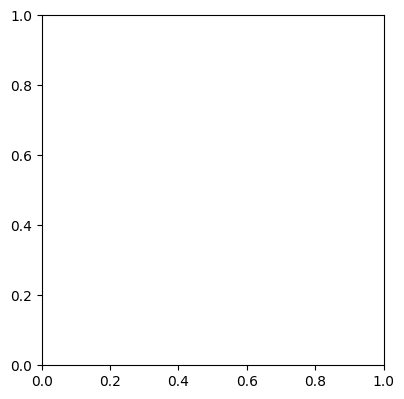

In [38]:
show_results()

# Pretrained LM-based classifier
used IndicBERT-based classifier as the LM-based classifier (hence-forth referred to as IndicLID-BERT) since it was amongst the best-performing romanized text classifiers and had maximum language coverage.

## froze all the layers except for the last softmax

In [20]:
from tqdm import tqdm
import pandas as pd
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import random
from transformers import AutoModel, AutoTokenizer
import transformers
import os

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


/home/saurabh1003/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [22]:

# IndicBERT-MLM-only

classes = 22

tokenizer = AutoTokenizer.from_pretrained("ai4bharat/IndicBERTv2-MLM-only")
model = AutoModelForSequenceClassification.from_pretrained("ai4bharat/IndicBERTv2-MLM-only", num_labels=classes)

model.to(device) 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/IndicBERTv2-MLM-only and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [23]:
# save and load the model
model_path = "./model/bhasha_abhijanan_IndicBert_based_classifier_model"
model.save_pretrained(model_path)

In [24]:
# freeze layers
for layer in model.bert.encoder.layer:
    for param in layer.parameters():
        param.requires_grad = False

In [25]:
#https://github.com/AI4Bharat/IndicLID/blob/master/final_runs_train/roman_model/finetuning/IndicBERT/freezed_bert_all_layer/train.py

In [26]:
code_to_name = {
    'Deva': 'Devanagari',
    'Beng': 'Bengali',
    'Gujr': 'Gujarati',
    'Taml': 'Tamil',
    'Arab': 'Arabic',
    'Latn': 'Latin',
    'Orya': 'Oriya',
    'Olck': 'Ol Chiki',
    'Knda': 'Kannada',
    'Mlym': 'Malayalam',
    'Mtei': 'Meetei Mayek',
    'Guru': 'Gurmukhi',
    'Telu': 'Telugu'
}

In [27]:
unicode_ranges = {
    'Deva': (0x0900, 0x097F),
    'Beng': (0x0980, 0x09FF),
    'Gujr': (0x0A80, 0x0AFF),
    'Taml': (0x0B80, 0x0BFF),
    'Arab': (0x0600, 0x06FF),
    'Latn': [(0x0000, 0x007F), (0x1E00, 0x1EFF)],
    'Orya': (0x0B00, 0x0B7F),
    'Olck': (0x1C50, 0x1C7F),
    'Knda': (0x0C80, 0x0CFF),
    'Mlym': (0x0D00, 0x0D7F),
    'Mtei': (0xABC0, 0xABFF),
    'Guru': (0x0A00, 0x0A7F),
    'Telu': (0x0C00, 0x0C7F)
}

In [28]:
label_to_language = {
    'asm': 'Assamese',
    'awa': 'Awadhi',
    'ben': 'Bengali',
    'bho': 'Bhojpuri',
    'brx': 'Bodo',
    'dgo': 'Dogri',
    'en': 'English',
    'gom': 'Konkani',
    'guj': 'Gujarati',
    'hin': 'Hindi',
    'hne': 'Chhattisgarhi',
    'kan': 'Kannada',
    'kas': 'Kashmiri',
    'lus': 'Mizo',
    'mag': 'Magahi',
    'mai': 'Maithili',
    'mal': 'Malayalam',
    'mar': 'Marathi',
    'mni': 'Manipuri',
    'npi': 'Nepali',
    'ory': 'Odia',
    'pan': 'Punjabi',
    'san': 'Sanskrit',
    'sat': 'Santali',
    'snd': 'Sindhi',
    'tam': 'Tamil',
    'tel': 'Telugu',
    'urd': 'Urdu'
}

In [29]:
# Updated function to check if a character belongs to a specific script based on unicode_ranges
def get_unicode_script(char):
    """
    Returns the script category for a given character based on unicode_ranges.
    """
    code = ord(char)
    for script, range_or_ranges in unicode_ranges.items():
        if isinstance(range_or_ranges, list):  # For scripts with multiple ranges
            for start, end in range_or_ranges:
                if start <= code <= end:
                    return script
        elif range_or_ranges[0] <= code <= range_or_ranges[1]:
            return script
    return None

# Update the results to identify each label's counts of single and multi-script entries
results = []
# Define helper functions for script analysis based on Unicode
def is_single_script(text):
    """
    Checks if the text has only one script based on Unicode blocks.
    """
    scripts = set()
    for char in text:
        if char.isalpha():  # Only consider alphabetic characters
            script = get_unicode_script(char)
            if script:
                scripts.add(script)
            if len(scripts) > 1:
                return False
    return True


# Function to extract language and script from label
def extract_language_and_script(label):
    """
    Extracts language and script names from the label based on known codes.
    """
    parts = label.split('_')
    lang_code = parts[-2]  # Language code is in the middle
    language_name = label_to_language.get(lang_code.lower(), 'Unknown')
    script_code = parts[-1]  # Script code is at the end

    # Map script code to full name
    script_name = code_to_name.get(script_code, 'Unknown')
    #language_name = lang_code.upper()  # Assuming language names can be derived from code (e.g., 'hin' -> 'HIN')
    
    return language_name, script_name

# Update results creation to include full language and script names
results = []

for label, group in df.groupby('lang_tag'):
    language, script = extract_language_and_script(label)
    single_script_count = group['sentance'].apply(is_single_script).sum()
    multi_script_count = len(group) - single_script_count
    results.append({
        'label': label,
        'language': language,
        'script': script,
        'single_script': single_script_count,
        'multi_script': multi_script_count
    })


# Convert results into a DataFrame
summary_df = pd.DataFrame(results)

# Display the updated summary to user
print(summary_df)


                label       language        script  single_script  \
0   __label__asm_Beng       Assamese       Bengali          10540   
1   __label__awa_Deva         Awadhi    Devanagari            962   
2   __label__ben_Beng        Bengali       Bengali          30103   
3   __label__bho_Deva       Bhojpuri    Devanagari            864   
4   __label__brx_Deva           Bodo    Devanagari            984   
5   __label__dgo_Deva          Dogri    Devanagari            963   
6    __label__en_Latn        English         Latin          56788   
7   __label__gom_Deva        Konkani    Devanagari            976   
8   __label__guj_Gujr       Gujarati      Gujarati          49717   
9   __label__hin_Deva          Hindi    Devanagari          54837   
10  __label__hne_Deva  Chhattisgarhi    Devanagari            906   
11  __label__kan_Knda        Kannada       Kannada          35303   
12  __label__kas_Arab       Kashmiri        Arabic            929   
13  __label__kas_Deva       Kashmi

In [30]:
# Define the preferred script order
script_order = ['Devanagari', 'Arabic', 'Latin']

# Add a helper column for sorting based on the script order
summary_df['script_order'] = summary_df['script'].apply(lambda x: script_order.index(x) if x in script_order else len(script_order))

# Sort the DataFrame first by the custom script order and then by the language for consistency
sorted_summary_df = summary_df.sort_values(by=['script_order', 'language']).drop(columns=['script_order'])

# Display the sorted summary to user
print(sorted_summary_df)

                label       language        script  single_script  \
1   __label__awa_Deva         Awadhi    Devanagari            962   
3   __label__bho_Deva       Bhojpuri    Devanagari            864   
4   __label__brx_Deva           Bodo    Devanagari            984   
10  __label__hne_Deva  Chhattisgarhi    Devanagari            906   
5   __label__dgo_Deva          Dogri    Devanagari            963   
9   __label__hin_Deva          Hindi    Devanagari          54837   
13  __label__kas_Deva       Kashmiri    Devanagari            718   
7   __label__gom_Deva        Konkani    Devanagari            976   
15  __label__mag_Deva         Magahi    Devanagari            985   
16  __label__mai_Deva       Maithili    Devanagari            924   
18  __label__mar_Deva        Marathi    Devanagari          36780   
21  __label__npi_Deva         Nepali    Devanagari            904   
24  __label__san_Deva       Sanskrit    Devanagari            902   
27  __label__snd_Deva         Sind

In [31]:
def detect_script(text):
    # Initialize counts for each script
    script_count = {script: 0 for script in unicode_ranges}
    
    # Check each character in text
    for char in text:
        char_code = ord(char)
        for script, ranges in unicode_ranges.items():
            # Handle multiple ranges (like Latin)
            if isinstance(ranges, list):
                if any(start <= char_code <= end for start, end in ranges):
                    script_count[script] += 1
            else:
                start, end = ranges
                if start <= char_code <= end:
                    script_count[script] += 1
    
    # Identify the script with the most characters in the sentence
    detected_script = max(script_count, key=script_count.get)
    return detected_script if script_count[detected_script] > 0 else "Unknown"

In [32]:
# Apply the detection function on the DataFrame and compare results
df["detected_script"] = df["sentance"].apply(detect_script)

In [33]:
df.head()

,sentance,lang_tag,detected_script
0,"সোমবাৰে , ষ্টেনফ ' ৰ্ড ইউনিভাৰচিটি স্কুল অৱ মে...",__label__asm_Beng,Beng
1,"শীৰ্ষ গৱেষকে কয় যে এইটোৱে কেন্সাৰ , যক্ষ্মা , ...",__label__asm_Beng,Beng
2,স্থানীয় সময় ( 0230 utc ) অনুসৰি পুৱা 9 : 30 ...,__label__asm_Beng,Beng
3,পাইলটগৰাকী স্কুৱাড্ৰন লীডাৰ ডিলক্ৰিট পাটাভি বু...,__label__asm_Beng,Beng
4,স্থানীয় সংবাদ মাধ্যমে সঁহাৰি জনাওতে বিমানবন্দৰ...,__label__asm_Beng,Beng


In [34]:
df["expected_script"] = df["lang_tag"].str.split('_').str[-1]

In [35]:
df.head()

,sentance,lang_tag,detected_script,expected_script
0,"সোমবাৰে , ষ্টেনফ ' ৰ্ড ইউনিভাৰচিটি স্কুল অৱ মে...",__label__asm_Beng,Beng,Beng
1,"শীৰ্ষ গৱেষকে কয় যে এইটোৱে কেন্সাৰ , যক্ষ্মা , ...",__label__asm_Beng,Beng,Beng
2,স্থানীয় সময় ( 0230 utc ) অনুসৰি পুৱা 9 : 30 ...,__label__asm_Beng,Beng,Beng
3,পাইলটগৰাকী স্কুৱাড্ৰন লীডাৰ ডিলক্ৰিট পাটাভি বু...,__label__asm_Beng,Beng,Beng
4,স্থানীয় সংবাদ মাধ্যমে সঁহাৰি জনাওতে বিমানবন্দৰ...,__label__asm_Beng,Beng,Beng


In [36]:
# Calculate accuracy
correct_matches = (df["detected_script"] == df["expected_script"]).sum()
accuracy = correct_matches / len(df) * 100

print(f"Accuracy of script detection: {accuracy}%")

# Filter the DataFrame for mismatches
mismatches = df[df["detected_script"] != df["expected_script"]]

# Print the mismatched rows
print("Mismatched rows:")
#print(mismatches[["sentance", "lang_tag", "detected_script", "expected_script"]])
mismatches[["sentance"]].head()


Accuracy of script detection: 99.76870956838887%
Mismatched rows:


,sentance
3028,pbs शो के दू दर्जन से जादा एम्मी अवार्ड मिलल ब...
3277,animal liberation अउर royal society for the pr...
9207,"& quot ; हमन जम्मों झि बस सदमा म रहेन , & quo..."
11048,۔hesperonychus elizabethae چھَ dromaeosauridae...
11302,ترکیہک diva sezen aksuکۄٚر پٲرفارم اِٹلیکِس te...


In [37]:

# Function to detect script for each character in a word
def detect_word_script(char):
    char_code = ord(char)
    for script, ranges in unicode_ranges.items():
        if isinstance(ranges, list):
            if any(start <= char_code <= end for start, end in ranges):
                return script
        else:
            start, end = ranges
            if start <= char_code <= end:
                return script
    return "Unknown"

# Function to check if a sentence contains words in multiple scripts
def detect_mixed_script(sentence):
    words = sentence.split()
    word_scripts = set()

    for word in words:
        # Get the dominant script for each word
        script_count = {}
        for char in word:
            script = detect_word_script(char)
            if script != "Unknown":
                script_count[script] = script_count.get(script, 0) + 1
        # Get the most common script in the word
        if script_count:
            dominant_script = max(script_count, key=script_count.get)
            word_scripts.add(dominant_script)

    return len(word_scripts) > 1

# Apply detection function on DataFrame
df_mixed_script["mixed_script"] = df["sentance"].apply(detect_mixed_script)

# Display sentences with mixed scripts
mixed_script_sentences = df_mixed_script[df_mixed_script["mixed_script"] == True]
print("Sentences with mixed scripts:")
print(mixed_script_sentences[["sentance", "lang_tag", "mixed_script"]])


NameError: name 'df_mixed_script' is not defined

In [ ]:
mismatched_sentences_set = set(mismatches["sentance"])
mixed_script_sentences_set = set(mixed_script_sentences["sentance"])
# Output results

unmatched_sentences = mismatched_sentences_set - mixed_script_sentences_set

# Output results
if not unmatched_sentences:
    print("All mismatched sentences are in mixed_script sentences.")
else:
    print("Some mismatched sentences are not in mixed_script sentences:")
    print(unmatched_sentences)

In [ ]:
len(mixed_script_sentences)

In [ ]:
len(mismatches)

In [ ]:
# Filter out rows where detected_script matches expected_script
df_non_code_mixed = df[df["detected_script"] == df["expected_script"]].reset_index(drop=True)

# Check if 'mixed_script' column exists and drop it
if 'mixed_script' in df_non_code_mixed.columns:
    df_non_code_mixed.drop(columns=['mixed_script'], inplace=True)

# Display the updated DataFrame
df_non_code_mixed.head()
